## **SLIC Superpixel Clustering on Rice Field Heatmaps**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.color import rgb2lab
from PIL import Image
import os
import re
import cv2

In [3]:
# Load the image
folder_path = '/home/soumyajit/ADEChallengeData2016/images/training'
all_input_images = sorted(os.listdir(folder_path))
output_path = '/home/soumyajit/ADEChallengeData2016/images/training_Slic_Merged_Segments'
os.makedirs(output_path, exist_ok=True)

In [4]:
all_input_images[4]

'ADE_train_00000005.jpg'

In [5]:
threshold = 30




In [6]:
# SLIC Superpixel Segmentation Parameters
num_clusters = 300
compactness = 9

In [7]:
# lis = [1701]

In [8]:
def track_sch_skips(input_image):
  file_path = './single_ch_skips_new.txt'
  with open(file_path, "a") as f:
    f.write(input_image)

In [9]:
def smoothen(seg_arr, median_replaced_img):
  mri = median_replaced_img.copy()
  for label in np.unique(seg_arr):
    cluster = (seg_arr == label)
    mri[cluster] = np.max(median_replaced_img[cluster], axis=0)

  return mri

In [10]:
def find_extreme_indices(array):
  '''
  Finds the extreme points by 2.a
  '''
  # Find the indices of True elements
  indices = np.argwhere(array)
  # print(indices)
  if len(indices) == 0:
      return None

  # Find the coordinates with extreme values
  leftmost = indices[np.argmin(indices[:, 1])]
  rightmost = indices[np.argmax(indices[:, 1])]
  topmost = indices[np.argmin(indices[:, 0])]
  bottommost = indices[np.argmax(indices[:, 0])]

  return leftmost, rightmost, topmost, bottommost

In [11]:
def four_extreme_merge(segmentation_arr, median_replaced_img):

  # Make a dictionary containing i, j values such that if we add it to original pixel coodinate we get the outer pixel
  # For example: Outer Point of leftmost point L(i, j) would be a arbitrary point K(i, j - 1)
  # That means if we add (0, -1) to L(i, j) it will give the outer point
  outer_side_dict = {'leftmost': (0, -1), 'rightmost':(0, 1), 'topmost':(-1, 0), 'bottommost': (1, 0)}
  # print(np.unique(segmentation_arr))
  sa = segmentation_arr.copy()
  for label in np.unique(segmentation_arr):
    # Individually selects labels and get the boolean array for find_extreme_indices
    cluster = segmentation_arr == label
    indices = find_extreme_indices(cluster)

    if indices is None:
      continue
    else:
      leftmost, rightmost, topmost, bottommost = indices

      for key, value in outer_side_dict.items():
        row, col = eval(key)

        outer = eval(key) + value
        outer_row, outer_col = outer

        try:
          pixel_median = median_replaced_img[row, col]
          neighbor_median = median_replaced_img[outer_row, outer_col]
          neighbor_label = segmentation_arr[outer_row, outer_col]
          pixel_label = segmentation_arr[row, col]
          
          if abs(neighbor_median.astype('float') - pixel_median.astype('float')) <= threshold:
            sa[segmentation_arr == neighbor_label] = pixel_label
            # median_replaced_img[segmentation_arr == pixel_label] = pixel_median

        except IndexError:
          continue

  return sa

In [12]:
from multiprocessing import Pool
from itertools import product

In [13]:
img_copy = None

In [14]:
# def process_single_image(args):
#     folder_path, output_path, num_clusters, compactness, input_image = args
#     counter = 0

#     image_path = os.path.join(folder_path, input_image)
#     image_number = re.findall(r'\d+', image_path)
#     image = np.array(Image.open(image_path))

#     # Skip all the single-channel image and keep track of it
#     if len(image.shape) != 3:
#         return 1  # Indicate that this image was skipped

#     segmentation_array = slic(image, n_segments=num_clusters, compactness=compactness)
#     if cv is True:
#         lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[:, :, 0]
#     if sk is True:
#         lab_image = rgb2lab(image)[:, :, 0]

#     for label in np.unique(segmentation_array):
#         cluster = lab_image[segmentation_array == label]
#         cluster_median = np.median(cluster, axis=0)
#         lab_image[segmentation_array == label] = cluster_median

#     # Merge Similar Clusters
#     print('Old: ', len(np.unique(segmentation_array)))
#     new_segmentation_arr = four_extreme_merge(segmentation_array, lab_image)
#     new_median_replaced_image = smoothen(new_segmentation_arr, lab_image)
#     print('New: ', len(np.unique(new_segmentation_arr)))

#     # print()

#     # Convert the lab_image to PIL Image
#     lab_image_pil = Image.fromarray(new_median_replaced_image.astype(np.uint8), mode='L')

#     # Save the lab_image
#     image_name = f"SLIC_mask_{image_number[1]}.png"
#     save_path = os.path.join(output_path, image_name)
#     lab_image_pil.save(save_path)

#     return 0  # Indicate successful processing
#     # return new_median_replaced_image

def replace_by_median(sa,li):
    sal = 0*sa
    for label in np.unique(sa):
        cluster = li[sa == label]
        cluster_median = np.median(cluster, axis=0)

        sal[sa == label] = cluster_median
    return sal

def process_single_image(args):
    folder_path, output_path, num_clusters, compactness, input_image = args
    counter = 0

    image_path = os.path.join(folder_path, input_image)
    image_number = re.findall(r'\d+', image_path)
    image = np.array(Image.open(image_path))

    # Skip all the single-channel image and keep track of it
    if len(image.shape) != 3:
        return 1  # Indicate that this image was skipped

    segmentation_array = slic(image, n_segments=num_clusters, compactness=compactness)
    lab_image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)[:, :, 0]

    segmentation_array_lab = replace_by_median(segmentation_array,lab_image)
    new_segmentation_array = four_extreme_merge(segmentation_array,segmentation_array_lab)
    new_segmentation_array_lab = replace_by_median(new_segmentation_array,lab_image)

    new_new_segmentation_array = new_segmentation_array.copy()
    new_new_segmentation_array_lab = new_segmentation_array_lab.copy()

    for _ in range(50):
        nnsa = new_new_segmentation_array.copy()
        new_new_segmentation_array = four_extreme_merge(new_new_segmentation_array,new_new_segmentation_array_lab)
        nnsal = new_new_segmentation_array_lab.copy()
        new_new_segmentation_array_lab = replace_by_median(new_new_segmentation_array,lab_image)
        if np.all(new_new_segmentation_array_lab==nnsal):
            break

    # Convert the lab_image to PIL Image
    #lab_image_pil = Image.fromarray((new_median_replaced_image * 2.55).astype(np.uint8), mode='L')
    lab_image_pil = Image.fromarray(new_new_segmentation_array_lab.astype(np.uint8), mode='L')
    # Save the lab_image
    # image_number = re.findall(r'\d+', image_path)
    image_name = f"SLIC_mask_{image_number[1]}.png"
    save_path = os.path.join(output_path, image_name)

    lab_image_pil.save(save_path)
    if counter % 100 == 0:
        print(counter, end=", ")
    counter += 1


def process(input_images, folder_path, output_path, num_clusters, compactness, num_processes=4):
    args_list = [(folder_path, output_path, num_clusters, compactness, input_image) for input_image in input_images]
    with Pool(num_processes) as pool:
        results = pool.map(process_single_image, args_list)

    # counter_skipped = sum(results)
    # total_images = len(input_images)
    # counter_processed = total_images - counter_skipped

    # print(f"Processed {counter_processed} images.")
    # print(f"Skipped {counter_skipped} single-channel images.")

In [15]:
# process(all_input_images, folder_path, output_path, num_clusters, compactness, 35)

In [25]:
# cv = False
# sk = True
threshold =4.5
process(all_input_images[:10], folder_path, output_path, num_clusters, compactness, 35)

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [26]:
img = cv2.imread('/home/soumyajit/ADEChallengeData2016/images/training_Slic_Merged_Segments/SLIC_mask_00000006.png', cv2.IMREAD_UNCHANGED)
len(np.unique(img))

array([ 11,  12,  16, 101, 111, 112, 117, 118, 119, 120, 124, 125, 126,
       127, 132, 135, 136, 137, 140, 143, 144, 146, 149, 150, 151, 152,
       155, 156, 157, 161, 162, 164, 165, 166, 170, 171, 173, 175, 176,
       178, 179, 180, 181, 182, 183, 185, 187, 189, 192, 193, 194, 195,
       198, 199, 201, 202, 208, 209, 220, 226, 234, 241, 248, 251],
      dtype=uint8)

In [18]:
# cv = True
# sk = False
threshold = 20
process(all_input_images[0:5], folder_path, output_path, num_clusters, compactness, 35)

0, 0, 0, 0, 0, 

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [55]:
args_list = [folder_path, output_path, num_clusters, compactness, all_input_images[47]]
img_cp = process_single_image(args_list)

Old:  260
New:  192


In [40]:
img_copy

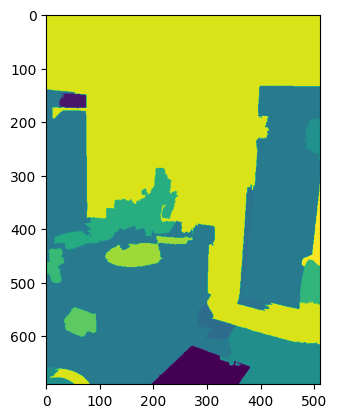

In [41]:
import matplotlib.pyplot as plt
plt.imshow(img_cp)

In [21]:
import cv2

In [24]:
lab_image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)[:,:,0]

In [25]:
for label in np.unique(segmentation_array):
    cluster = lab_image[segmentation_array == label]
    cluster_median = np.median(cluster, axis=0)

    lab_image[segmentation_array == label] = cluster_median


In [26]:
lab_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [129, 129, 129, ..., 144, 144, 144],
       [129, 129, 129, ..., 144, 144, 144],
       [129, 129, 129, ..., 144, 144, 144]], dtype=uint8)

In [134]:
segmentation_array = slic(image, n_segments=num_clusters, compactness=compactness)
lab_image = rgb2lab(image)[:, :, 0]

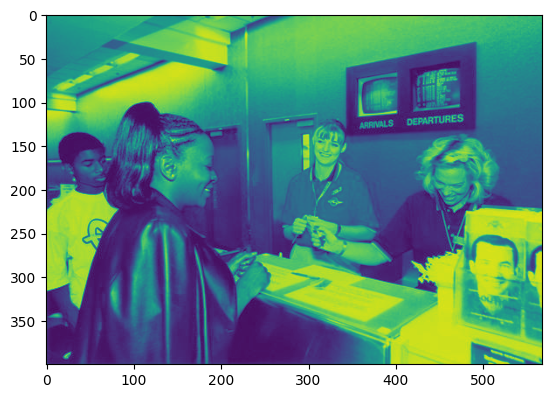

In [135]:
plt.imshow(lab_image)

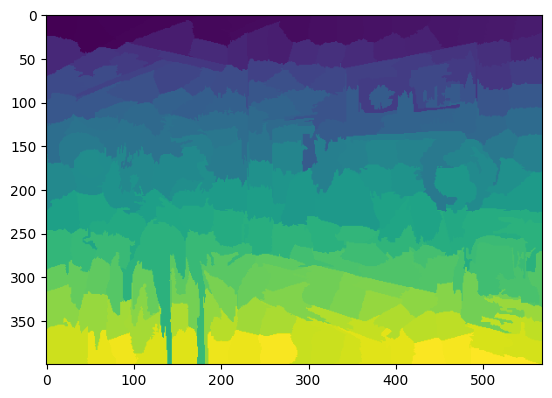

In [136]:
plt.imshow(segmentation_array)

In [137]:
for label in np.unique(segmentation_array):
    cluster = lab_image[segmentation_array == label]
    cluster_median = np.median(cluster, axis=0)

    lab_image[segmentation_array == label] = cluster_median

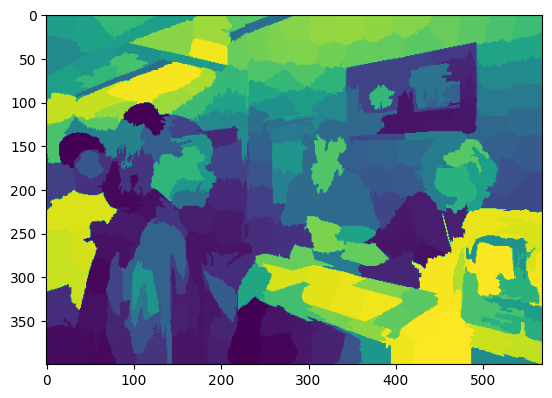

In [138]:
plt.imshow(lab_image)

In [139]:
sa = segmentation_array.copy()
li = lab_image.copy()

In [140]:
new_segmentation_arr = four_extreme_merge(segmentation_array, lab_image)

In [143]:
np.all(segmentation_array==sa)

True

In [144]:
np.all(lab_image==li)

True

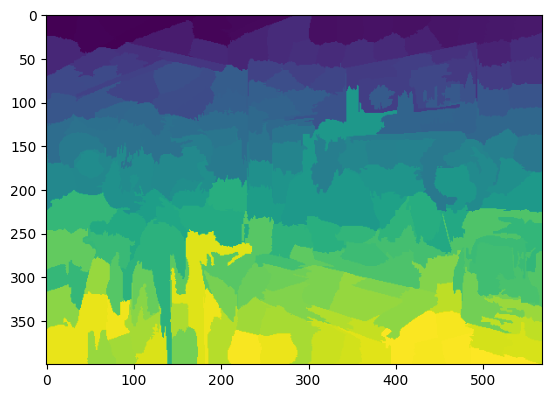

In [145]:
plt.imshow(new_segmentation_arr)

In [147]:
new_median_replaced_image = smoothen(new_segmentation_arr, lab_image)

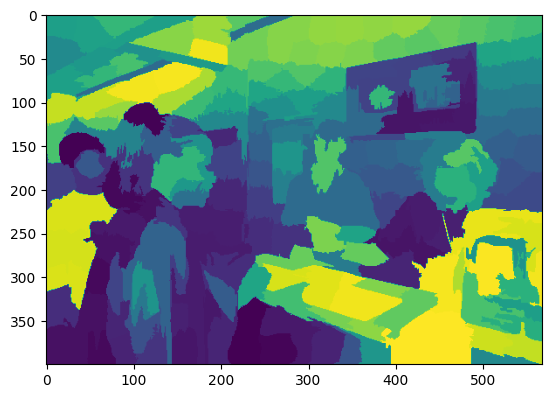

In [148]:
plt.imshow(new_median_replaced_image)

In [150]:
np.all(new_median_replaced_image==lab_image)

False

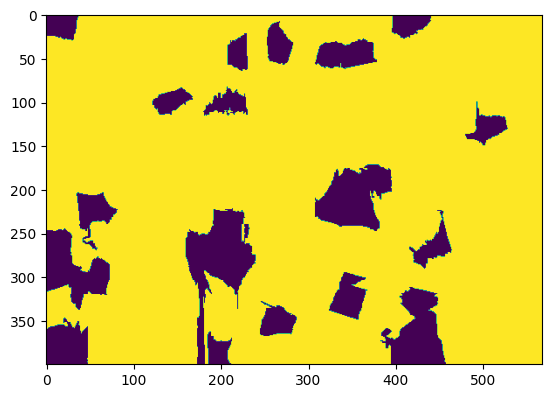

In [152]:
plt.imshow(lab_image==new_median_replaced_image)

In [153]:
lab_image

array([[52.24846822, 52.24846822, 52.24846822, ..., 63.70090225,
        63.70090225, 63.70090225],
       [52.24846822, 52.24846822, 52.24846822, ..., 63.70090225,
        63.70090225, 63.70090225],
       [52.24846822, 52.24846822, 52.24846822, ..., 63.70090225,
        63.70090225, 63.70090225],
       ...,
       [ 7.23991309,  7.23991309,  7.23991309, ..., 82.63387762,
        82.63387762, 82.63387762],
       [ 7.23991309,  7.23991309,  7.23991309, ..., 82.63387762,
        82.63387762, 82.63387762],
       [ 7.23991309,  7.23991309,  7.23991309, ..., 82.63387762,
        82.63387762, 82.63387762]])

In [154]:
new_median_replaced_image

array([[53.14909684, 53.14909684, 53.14909684, ..., 63.70090225,
        63.70090225, 63.70090225],
       [53.14909684, 53.14909684, 53.14909684, ..., 63.70090225,
        63.70090225, 63.70090225],
       [53.14909684, 53.14909684, 53.14909684, ..., 63.70090225,
        63.70090225, 63.70090225],
       ...,
       [ 8.28615764,  8.28615764,  8.28615764, ..., 82.63387762,
        82.63387762, 82.63387762],
       [ 8.28615764,  8.28615764,  8.28615764, ..., 82.63387762,
        82.63387762, 82.63387762],
       [ 8.28615764,  8.28615764,  8.28615764, ..., 82.63387762,
        82.63387762, 82.63387762]])

In [155]:
new_segmentation_arr

array([[  2,   2,   2, ...,  16,  16,  16],
       [  2,   2,   2, ...,  16,  16,  16],
       [  2,   2,   2, ...,  16,  16,  16],
       ...,
       [196, 196, 196, ..., 191, 191, 191],
       [196, 196, 196, ..., 191, 191, 191],
       [196, 196, 196, ..., 191, 191, 191]])

In [157]:
lab_image[new_segmentation_arr==2]

array([52.24846822, 52.24846822, 52.24846822, ..., 53.14909684,
       53.14909684, 53.14909684])